<a href="https://colab.research.google.com/github/zzhining/public_data_analysis/blob/main/w14_time_series_data_analysis(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시계열 데이터 분석
- 데이터 셋: [국민건강보험공단 질병예측 정보](https://www.data.go.kr/data/15083145/fileData.do) 중 `실제진료정보_감기_시도.csv` 데이터 분석
    - 수요조사 결과에 따라 관심도가 높은 4대 질병에 대한 위험도 및 예측정보 제공
    - 4대질병(눈병, 천식, 감기, 피부염) 사전 예방을 위한 전국 시도 및 시군구별 질병예측정보
    - 4개질병(눈병, 천식, 감기, 피부염) 시군구별 과거 진료건수 제공


### 환경 셋팅

In [1]:
!pip install --upgrade --no-deps statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/zzhining/time_series_basic.git

fatal: destination path 'time_series_basic' already exists and is not an empty directory.


# 계절성 #

*실제진료정보_감기_시도.csv* 데이터셋을 사용하여 계절성을 확인하고, 시계열 예측 모델을 생성합니다.

## 1. 데이터 불러오기

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import time_series_basic.util as util

df = pd.read_csv("https://raw.githubusercontent.com/zzhining/public_data_analysis/main/dataset/%EC%8B%A4%EC%A0%9C%EC%A7%84%EB%A3%8C%EC%A0%95%EB%B3%B4_%EA%B0%90%EA%B8%B0_%EC%8B%9C%EB%8F%84.csv", encoding='cp949')
df.head()

,날짜,시도지역코드,발생건수(건)
0,20140101,11,5992
1,20140101,26,3158
2,20140101,27,2190
3,20140101,28,3426
4,20140101,29,2635


In [4]:
df.rename(columns={"날짜": "date", "시도지역코드": "code", "발생건수(건)": "flu"}, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41905 entries, 0 to 41904
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   date    41905 non-null  int64
 1   code    41905 non-null  int64
 2   flu     41905 non-null  int64
dtypes: int64(3)
memory usage: 982.3 KB


## 데이터 전처리
----
`date` 컬럼을 int64 형태로 인식하고 있으므로, datetime64 형태로 변환

In [6]:
def getDate(data):
    data = str(data)
    year = data[0:4]
    month = data[4:6]
    day = data[6:8]
    return year+'-'+month+'-'+day
df['date'] = df['date'].apply(getDate).astype('datetime64')
df.head()

,date,code,flu
0,2014-01-01,11,5992
1,2014-01-01,26,3158
2,2014-01-01,27,2190
3,2014-01-01,28,3426
4,2014-01-01,29,2635


In [7]:
df = df.set_index("date").to_period("D")

`시도지역코드`가 11인 지역의 데이터만 분석하기 위해 데이터 필터링

In [8]:
df11 = df.query("code in [11]")

In [9]:
df11.drop(['code'], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
df11.head()

,flu
date,
2014-01-01,5992
2014-01-02,101309
2014-01-03,84210
2014-01-04,74899
2014-01-05,7695


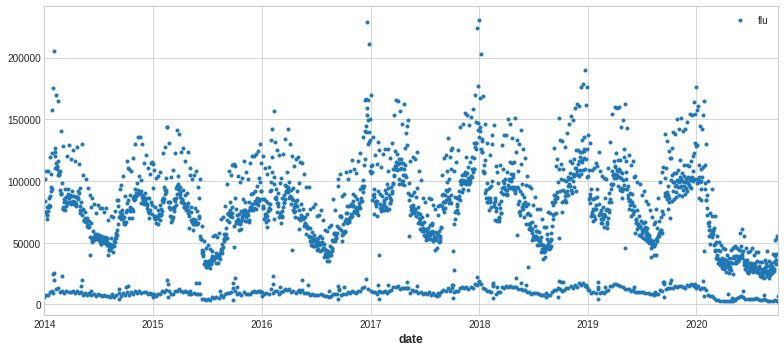

In [11]:
util.init_plt()
df11.plot(style=".")

2020년 이후 데이터는 이전 연도의 패턴과 다르므로, 2020년 이전의 데이터만 분석에 사용

In [12]:
df11 = df11[df11.index < '2020-1-1']

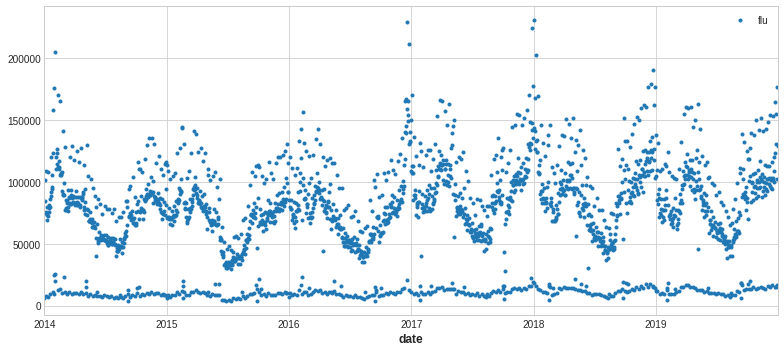

In [13]:
df11.plot(style=".")

공휴일, 주말의 경우 진료의 진단 환자의 수가 줄어들기 때문에 분석에서 제외. 감기 환자 진단 수가 30,000건 이상인 경우만 분석에서 사용

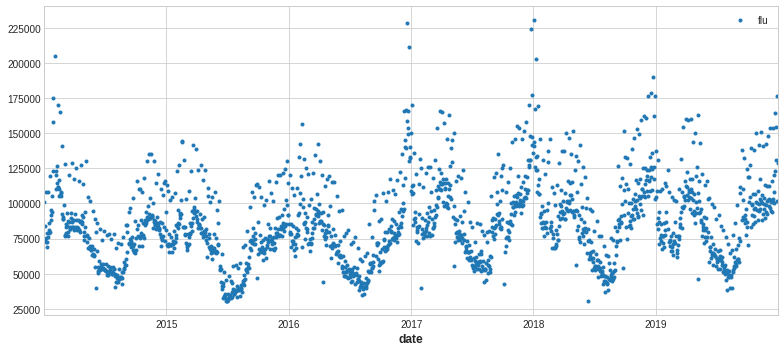

In [14]:
df11 = df11[df11.flu > 30000]
df11.plot(style=".")

## 2. 계절성 확인하기

### 계절성 플롯(Seasonal plot)

연도별, 주차별 계절성 플롯을 그려봅니다.

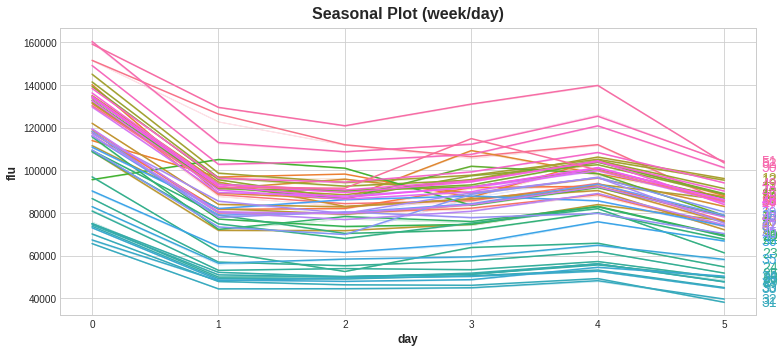

In [15]:
X = df11.copy()

# 주차별 계절성 플롯
X["day"] = X.index.dayofweek  # 요일
X["week"] = X.index.week  # 주
util.seasonal_plot(X, y="flu", period="week", freq="day")

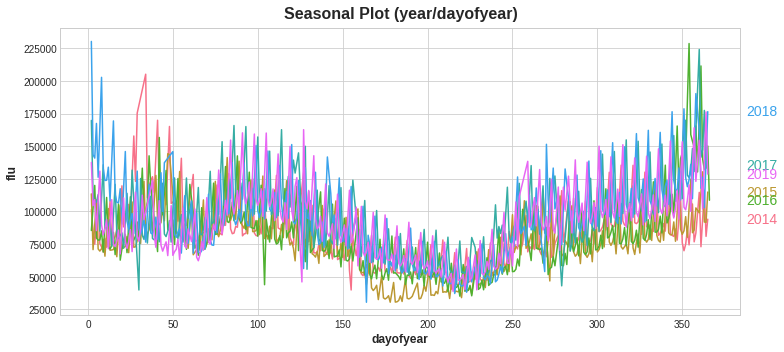

In [16]:
# 연도별 계절성 플롯
X["dayofyear"] = X.index.dayofyear # 연도의 시작일을 기준으로 며칠이 지났는지 설정
X["year"] = X.index.year # 연도
util.seasonal_plot(X, y="flu", period="year", freq="dayofyear");

###  스펙트럼 분석(Periodogram)

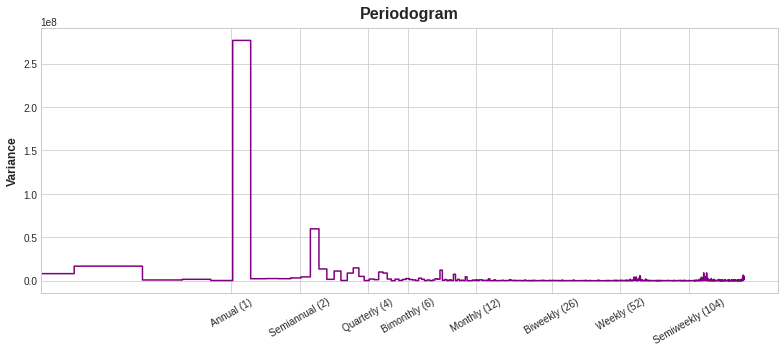

In [17]:
util.plot_periodogram(df11.flu);

## 3. 데이터 전처리

푸리에 속성 생성

In [18]:
df11.head()

,flu
date,
2014-01-02,101309
2014-01-03,84210
2014-01-04,74899
2014-01-06,108504
2014-01-07,75304


In [19]:
fourier = CalendarFourier(freq="A", order=10) # 연간("A"nnual) 계절성을 반영한 10 sin/cos 쌍

dp = DeterministicProcess(
    index=df11.index,
    constant=True,              
    order=1,                   
    seasonal=True,             
    additional_terms=[fourier],
    drop=True,                 
)

X = dp.in_sample() 
y = df11["flu"]

In [20]:
X.columns

Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)',
       'sin(4,freq=A-DEC)', 'cos(4,freq=A-DEC)', 'sin(5,freq=A-DEC)',
       'cos(5,freq=A-DEC)', 'sin(6,freq=A-DEC)', 'cos(6,freq=A-DEC)',
       'sin(7,freq=A-DEC)', 'cos(7,freq=A-DEC)', 'sin(8,freq=A-DEC)',
       'cos(8,freq=A-DEC)', 'sin(9,freq=A-DEC)', 'cos(9,freq=A-DEC)',
       'sin(10,freq=A-DEC)', 'cos(10,freq=A-DEC)'],
      dtype='object')

## 4. 학습

선형회귀 모델

In [21]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

## 5. 예측

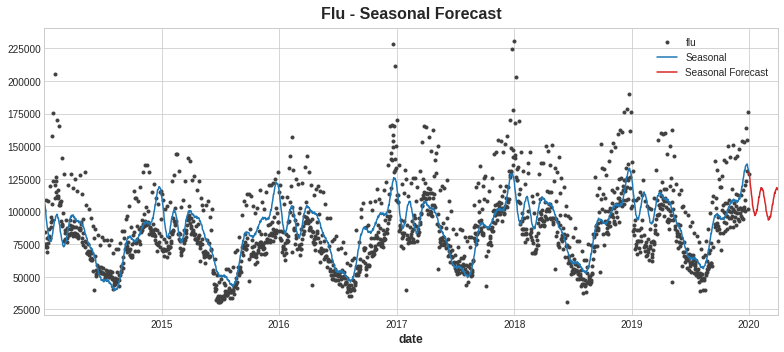

In [22]:
y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Flu - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

#  지연 속성 #



## 2. 지연 속성 확인하기

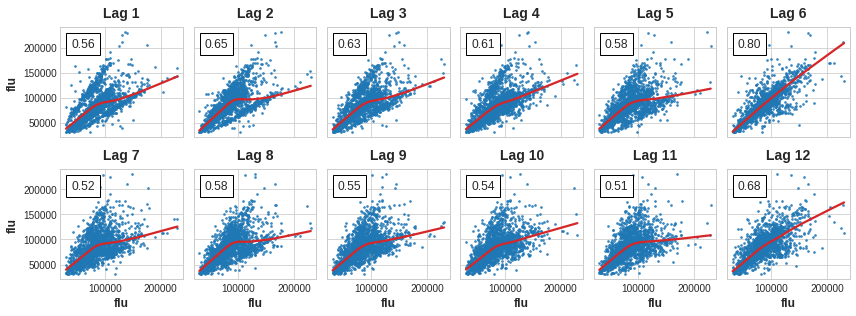

In [34]:
_= util.plot_lags(df11.flu, lags=12, nrows=2)

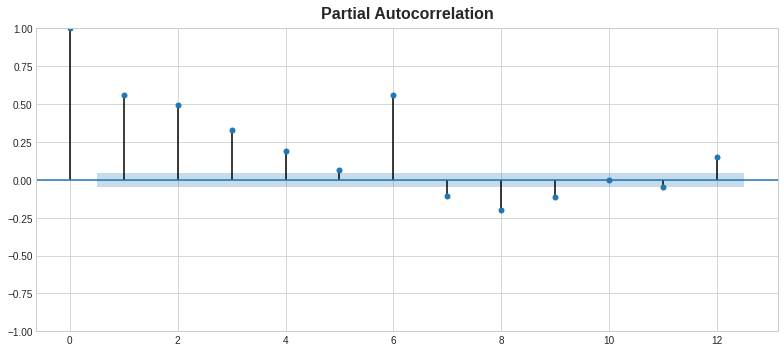

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_pacf(df11.flu, lags=12)

## 3. 데이터 전처리

In [26]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df11.flu, lags=4)
X = X.fillna(0.0)

In [28]:
from sklearn.model_selection import train_test_split
y = df11.flu.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

## 4. 학습

In [29]:
# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)

LinearRegression()

## 5. 예측

In [30]:
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

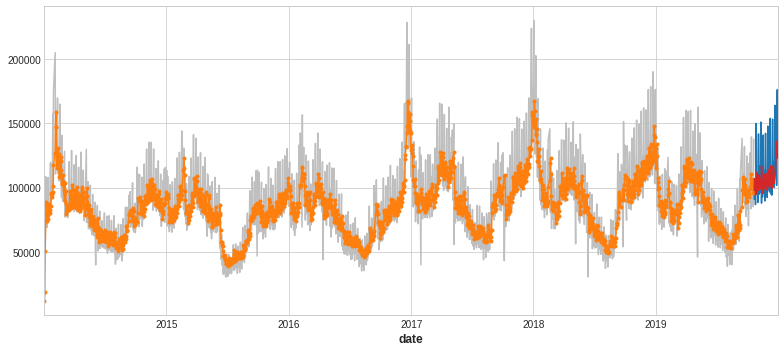

In [31]:
ax = y_train.plot(color="0.75", legend=False)
ax = y_test.plot()
ax = y_pred.plot(ax=ax, style=".-")
_ = y_fore.plot(ax=ax, color='C3')

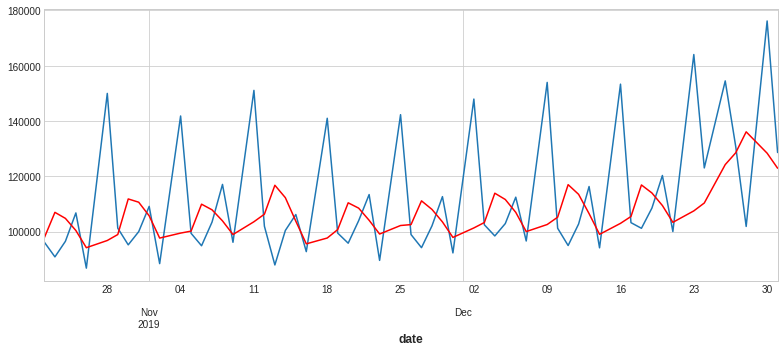

In [32]:
y_test.plot()
y_fore.plot(color='r')